In [1]:
import math
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
import torch.autograd as autograd
from segment_tree import MinSegmentTree, SumSegmentTree

import copy
from torch.distributions import Categorical
from datetime import datetime
import gymnasium as gym
import os, shutil
import argparse

import datetime
from shutil import copyfile
import sys
import traci
import timeit

from generator import TrafficGenerator
from memory import Memory     ## Prority Experience Memory 
from visualization import Visualization

from utils import import_train_configuration,set_sumo, set_train_path,get_model_path

import warnings
warnings.filterwarnings('ignore')

# Actions

In [2]:
# phase codes based on SUMO environment.net.xml 
PHASE_NS_GREEN = 0  # action 0 for Variable Order
PHASE_NS_YELLOW = 1
PHASE_NSL_GREEN = 2  # action 1 for Variable Order
PHASE_NSL_YELLOW = 3
PHASE_EW_GREEN = 4  # action 2 for Variable Order
PHASE_EW_YELLOW = 5
PHASE_EWL_GREEN = 6  # action 3 for Variable Order
PHASE_EWL_YELLOW = 7

# New phases added
PHASE_N_SL_GREEN = 8
PHASE_N_SL_YELLOW= 9
PHASE_E_SL_GREEN = 10
PHASE_E_SL_YELLOW= 11
PHASE_S_SL_GREEN = 12
PHASE_S_SL_YELLOW= 13
PHASE_W_SL_GREEN = 14
PHASE_W_SL_YELLOW= 15

# State

In [3]:
def _get_state():
    """
    Retrieve the state of the intersection from sumo, in the form of cell occupancy
    """
    state = np.zeros((3, 209, 206))   ## kind of like an RGB image
    lane = ["N2TL_0","N2TL_1","N2TL_2","E2TL_0","E2TL_1","E2TL_2","E2TL_3","S2TL_0","S2TL_1","S2TL_2","W2TL_0","W2TL_1","W2TL_2","W2TL_3"]
    # N, E, S, W
    #           N
    #   W               E
    #           S    
    car_list = traci.vehicle.getIDList()

    for car_id in car_list:
        lane_pos = traci.vehicle.getLanePosition(car_id)
        car_speed = traci.vehicle.getSpeed(car_id)
        lane_id = traci.vehicle.getLaneID(car_id)
        #Only information from incoming lanes
        if 'N2TL' in lane_id:            
            x = 100 + int(lane_id[-1])
            y = int(lane_pos//7.5)
            state[0][y][x] = 1 #presence / volume
            state[1][y][x] = car_speed / 50.0 # normalized velocity
            state[2][y][x] = traci.vehicle.getAccumulatedWaitingTime(car_id)/60.0 #waitingTime
            
        if 'E2TL' in lane_id:
            x = 205 - int(lane_pos//7.5)
            y = 99 + 1 + int(lane_id[-1])
            state[0][y][x] = 1 #presence / volume
            state[1][y][x] = car_speed / 50.0 #normalized velocity
            state[2][y][x] = traci.vehicle.getAccumulatedWaitingTime(car_id)/60.0 #waitingTime

        if 'S2TL' in lane_id:
            x = 100 + 3 + int(lane_id[-1])
            y = 207 + 1 - int(lane_pos//7.5)
            state[0][y][x] = 1 #presence / volume
            state[1][y][x] = car_speed / 50.0 #normalized velocity
            state[2][y][x] = traci.vehicle.getAccumulatedWaitingTime(car_id)/60.0 #waitingTime

        if 'W2TL' in lane_id:
            x = int(lane_pos//7.5)
            y = 99 + 1 + 4 + 3 - int(lane_id[-1])
            state[0][y][x] = 1 #presence / volume
            state[1][y][x] = car_speed /50.0 #normalized velocity
            state[2][y][x] = traci.vehicle.getAccumulatedWaitingTime(car_id)/60.0 #waitingTime

    #Return a partial view of the state
    return state[:, state.shape[1]//2 - 24: state.shape[1]//2 + 24, state.shape[2]//2 - 23: state.shape[2]//2 + 23]#.tolist()

# Environment

In [4]:
class Simulation:
    def __init__(self, Agent, TrafficGen, sumo_cmd, max_steps, green_duration, yellow_duration, num_states, num_actions, mode, device):
        self._Agent = Agent
        #self._Actor = Agent.actor
        #self._Critic= Agent.critic
        self._TrafficGen = TrafficGen
        self._step = 0
        self._sumo_cmd = sumo_cmd
        self._max_steps = max_steps 
        self._green_duration = green_duration
        self._yellow_duration = yellow_duration
        self._num_states = num_states
        self._num_actions = num_actions
        self._reward_store = []
        self._speed_store = []
        self._cumulative_wait_store = []
        self._avg_queue_length_store = []
        self._eval = mode
        self.dvc = device
        self.frame_idx = 0
        self.num_frames = 20*256
        self.update_cnt = 0
        self.training_losses = []

    def run(self, episode):
        """
        Runs an episode of simulation, then starts a training session
        """
        self.training = False
        start_time = timeit.default_timer()

        # first, generate the route file for this simulation and set up sumo
        if not self._eval:
            self._TrafficGen.generate_routefile(seed=episode)
        else:
            self._TrafficGen.generate_routefile(seed=800+episode)
        traci.start(self._sumo_cmd)
        print("Simulating...")

        # inits
        self._step = 0
        self._waiting_times = {}
        self._sum_neg_reward = 0
        self._sum_queue_length = 0
        self._sum_waiting_time = 0
        duration = [0,0,0,0,0,0,0,0]
        self._sum_speed = 0
        reward = 0
        re = 0
        current_phase = 0
        self.reward = 0
        done = 0
        old_action = 0
        last_queue = 0
        self._simulate(50)  ## Warm Environment
        self.updates = 0
        self.mean_loss = 0.0
        self.training_time = 0

        while self._step < self._max_steps:
            
            # get current state of the intersection
            current_state = _get_state()

            # calculate reward of previous action: 
            # waiting time = seconds waited by a car since the spawn in the environment, cumulated for every car in incoming lanes
            current_total_wait = self._collect_waiting_times()    
            
            # Current light phase
            current_phase = int(traci.trafficlight.getPhase("TL")/2)
            # Chosen action
            action = self._choose_action(current_state)
            last_queue = self._get_queue_length()

            # saving the data into the memory                
            # if the chosen phase is different from the last phase, activate the yellow phase
            if self._step != 0 and old_action != action:# and i == 0:
                self._set_yellow_phase(current_phase)
                self._simulate(self._yellow_duration)
                duration[action] = self._green_duration
                #last_queue = self._get_queue_length()
                # Perform chosen action on environment
                self._set_green_phase(action)
                self._simulate(self._green_duration)    
            elif self._step != 0 and old_action == action:
                #last_queue = self._get_queue_length()
                # Perform chosen action on environment
                self._set_green_phase(action)
                self._simulate(7)
            # Capture next state information
            reward = -self._get_queue_length() #+ last_queue
            if self._step != 0:
                next_state = _get_state()
                if self._step < self._max_steps - self._green_duration - self._yellow_duration:
                    done = 0
                else:
                    done = 1
                if not self._Agent.is_test:
                    self._Agent.transition += [reward, next_state, done]
                    if self._Agent.use_n_step:
                        one_step_transition = self._Agent.memory_n.store(*self._Agent.transition)
                    # 1-step transition
                    else:
                        one_step_transition = self._Agent.transition
                    # add a single step transition
                    if one_step_transition:
                        self._Agent.memory.store(*one_step_transition)
                    #self._Agent.put_data(current_state, action, reward, next_state, logprob_a, cat_hin.numpy(), cat_hout.numpy(), done, done) 
            fraction = min(self.frame_idx / self.num_frames, 1.0)
            self._Agent.beta = self._Agent.beta + fraction * (1.0 - self._Agent.beta)
            # saving only the meaningful reward to better see if the agent is behaving correctly
            #if reward < 0:
            self._sum_neg_reward += reward
            re += 1
            #old_action = action
            self.frame_idx +=1

            if len(self._Agent.memory) >= self._Agent.batch_size and not self._Agent.is_test:
                loss, training_time = self._Agent.update_model()
                self.training_time+=training_time
                losses.append(loss)
                self.update_cnt += 1
                self.mean_loss+=loss
                self.updates +=1                
                # if hard update is needed
                if self.update_cnt % self._Agent.target_update == 0:
                    self._Agent._target_hard_update()
        
        self.reward = self._sum_neg_reward/re
        self.mean_loss /=self.updates
        self.training_losses.append(self.mean_loss)
        print("Total Queue:",self._sum_queue_length, "  ", "Average Reward:", self.reward)
        print("Average Waiting time: {:.4f}".format(self._sum_waiting_time/1000))
        print("Average Speed: {:.4f}".format(self._sum_speed/self._max_steps))
        print("Average Queue length: {:.4f}".format(self._sum_queue_length / self._max_steps))
        print('Mean loss: {:.4f}'.format(self.mean_loss))
        self._save_episode_stats()
        traci.close()
        simulation_time = round(timeit.default_timer() - start_time, 1)
        if not self._eval: 
            return simulation_time-self.training_time, self.training_time
        else:
            return simulation_time, self.reward

    def _simulate(self, steps_todo):
        """
        Execute steps in sumo while gathering statistics
        """
        if (self._step + steps_todo) >= self._max_steps:  # do not do more steps than the maximum allowed number of steps
            steps_todo = self._max_steps - self._step

        while steps_todo > 0:
            traci.simulationStep()  # simulate 1 step in sumo
            self._step += 1 # update the step counter
            steps_todo -= 1
            queue_length = self._get_queue_length()
            self._sum_queue_length += queue_length
            self._sum_waiting_time += queue_length # 1 step while wating in queue means 1 second waited, for each car, therefore queue_lenght == waited_seconds
            speed = self._get_speed()
            self._sum_speed += speed
        
    def _collect_waiting_times(self):            # For reward 
        """
        Retrieve the waiting time of every car in the incoming roads
        """
        incoming_roads = ["E2TL", "N2TL", "W2TL", "S2TL"]
        car_list = traci.vehicle.getIDList()
        self._waiting_times = {}
        for car_id in car_list:
            wait_time = traci.vehicle.getAccumulatedWaitingTime(car_id)
            road_id = traci.vehicle.getRoadID(car_id)  # get the road id where the car is located
            if road_id in incoming_roads:  # consider only the waiting times of cars in incoming roads
                self._waiting_times[car_id] = wait_time 
            else:
                if car_id in self._waiting_times: # a car that was tracked has cleared the intersection
                    del self._waiting_times[car_id] 
                
        if len(self._waiting_times) == 0: 
            total_waiting_time = 0
        else: 
            total_waiting_time = sum(self._waiting_times.values())/len(self._waiting_times)
        return total_waiting_time 
    
    def _choose_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        selected_action = self._Agent.dqn(
            torch.FloatTensor(state).to(self.dvc)
        ).argmax()
        selected_action = selected_action.detach().cpu().numpy()
        
        if not self._Agent.is_test:
            self._Agent.transition = [state, selected_action]
        
        return selected_action

    def _set_yellow_phase(self, old_action):
        """
        Activate the correct yellow light combination in sumo
        """
        yellow_phase_code = old_action * 2 + 1 # obtain the yellow phase code, based on the old action (ref on environment.net.xml)
        traci.trafficlight.setPhase("TL", yellow_phase_code)

    def _set_green_phase(self, action_number):   ## For Variable Order Method 
        """
        Activate the correct green light combination in sumo
        """
        if action_number == 0:
            traci.trafficlight.setPhase("TL", PHASE_NS_GREEN)
        elif action_number == 1:
            traci.trafficlight.setPhase("TL", PHASE_NSL_GREEN)
        elif action_number == 2:
            traci.trafficlight.setPhase("TL", PHASE_EW_GREEN)
        elif action_number == 3:
            traci.trafficlight.setPhase("TL", PHASE_EWL_GREEN)
        elif action_number == 4:
            traci.trafficlight.setPhase('TL', PHASE_N_SL_GREEN)
        elif action_number == 5:
            traci.trafficlight.setPhase('TL', PHASE_E_SL_GREEN)
        elif action_number == 6:
            traci.trafficlight.setPhase('TL', PHASE_S_SL_GREEN)
        elif action_number == 7:
            traci.trafficlight.setPhase('TL', PHASE_W_SL_GREEN)

        # Add New phases (North Straight and Left, South Straight and Left, West Straight and Left, East Straight and Left)

    def _get_green(self,current_phase):       ## For Finetuning Method 
        if current_phase == 0:
            green = Duration_NS
        elif current_phase == 1:
            green = Duration_NSL
        elif current_phase == 2:
            green = Duration_EW
        elif current_phase == 3: 
            green = Duration_EWL
        else:
            green = Duration_N_SL
        
        return green

    def _get_queue_length(self):          # For evaluation 
        """
        Retrieve the number of cars with speed = 0 in every incoming lane
        """
        halt_N = traci.edge.getLastStepHaltingNumber("N2TL")
        halt_S = traci.edge.getLastStepHaltingNumber("S2TL")
        halt_E = traci.edge.getLastStepHaltingNumber("E2TL")
        halt_W = traci.edge.getLastStepHaltingNumber("W2TL")
        queue_length = halt_N + halt_S + halt_E + halt_W
        return queue_length
    
    def _get_speed(self):                  # For evaluation 
        total_speed = 0
        car_list = traci.vehicle.getIDList()
        for car_id in car_list:
            car_speed = traci.vehicle.getSpeed(car_id)
            total_speed +=car_speed
        if len(car_list) == 0: 
            s = 0
        else: 
            s = total_speed/len(car_list)
        return s
            
    def _save_episode_stats(self):
        """
        Save the stats of the episode to plot the graphs at the end of the session
        """
        self._reward_store.append(self.reward)  # how much negative reward in this episode
        self._speed_store.append(self._sum_speed / self._max_steps)
        self._cumulative_wait_store.append(self._sum_waiting_time)  # total number of seconds waited by cars in this episode
        self._avg_queue_length_store.append(self._sum_queue_length / self._max_steps)  # average number of queued cars per step, in this episode
    
    @property
    def reward_store(self):
        return self._reward_store

    @property
    def speed_store(self):
        return self._speed_store
    
    @property
    def cumulative_wait_store(self):
        return self._cumulative_wait_store

    @property
    def avg_queue_length_store(self):
        return self._avg_queue_length_store

# Prioritized Replay Buffer

In [5]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        n_step: int = 1, 
        gamma: float = 0.99
    ):
        self.obs_buf = np.zeros([size]+obs_dim, dtype=np.float32)
        self.next_obs_buf = np.zeros([size]+obs_dim, dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self, 
        obs: np.ndarray, 
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]
        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step Learning
            indices=idxs,
        )
    
    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # for N-step Learning
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )
    
    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

In [6]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.
    
    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
        
    """
    
    def __init__(
        self, 
        obs_dim: list,
        size: int, 
        batch_size: int = 32, 
        alpha: float = 0.6,
        n_step: int = 1, 
        gamma: float = 0.99,
    ):
        """Initialization."""
        assert alpha >= 0
        
        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha
        
        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
    def store(
        self, 
        obs: np.ndarray, 
        act: int, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)
        
        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size
        
        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0
        
        indices = self._sample_proportional()
        
        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])
        
        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,
        )
        
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight

# Noisy Layer

In [7]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    
        
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """

    def __init__(
        self, 
        in_features: int, 
        out_features: int, 
        std_init: float = 0.5,
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

# Dueling DQN with Noisy Layers

In [8]:
class Network(nn.Module):
    def __init__(
        self, 
        out_dim: int, 
        atom_size: int, 
        support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()
        
        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        # set common feature layer
        self.conv1 = nn.Conv2d(3, 16, (5,5), (1,1), padding='same')
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(16, 32, (3,3), (1,1), padding='same')
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        self.linear1 = nn.Linear(32*12*11, 256)
        
        # set advantage layer
        self.advantage_hidden_layer = NoisyLinear(256, 128)
        self.advantage_layer = NoisyLinear(128, out_dim * atom_size)

        # set value layer
        self.value_hidden_layer = NoisyLinear(256, 128)
        self.value_layer = NoisyLinear(128, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)
        
        return q
    
    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        #feature = self.feature_layer(x)
        x = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(x))))))
        x = x.view(-1, 32*12*11)
        feature = F.tanh(self.linear1(x))
        adv_hid = F.tanh(self.advantage_hidden_layer(feature))
        val_hid = F.tanh(self.value_hidden_layer(feature))
        
        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans
        
        return dist
    
    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

# Rainbow DQN Agent

In [9]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        observation_space (list): shape of state array
        actions (int): number of possible actions
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self, 
        observation_space: list,
        actions: int,
        memory_size: int,
        batch_size: int,
        target_update: int,
        #seed: int,
        gamma: float = 0.99,
        # PER parameters
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 3,
    ):
        """Initialization.
        
        Args:
            observation space (list): shape of state array
            actions (int): number of possible actions
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): determines how much prioritization is used
            beta (float): determines how much importance sampling is used
            prior_eps (float): guarantees every transition can be sampled
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
            n_step (int): step number to calculate n-step td error
        """

        self.obs = observation_space
        self.actions = actions
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        # NoisyNet: All attributes related to epsilon are removed
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        
        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            self.obs, memory_size, batch_size, alpha=alpha, gamma=gamma
        )
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                self.obs, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
            
        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(
            self.actions, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target = Network(
            self.actions, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        start_time = timeit.default_timer()
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]
        
        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)
        
        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)
        
        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss
            
            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()
        
        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)
        
        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()
        end_time = timeit.default_timer()
        return loss.item(), end_time-start_time
                        
    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).reshape(-1, 3, 48, 46).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).reshape(-1, 3, 48, 46).to(device)
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

In [10]:
if __name__ == "__main__":
    gui = False
    max_steps = 3600
    model_to_test = 1
    n_cars_generated= 1000
    green_duration = 7
    yellow_duration = 6
    total_episodes = 50
    num_actions = 8
    num_states = [3,48,46]
    
    config = import_train_configuration(config_file='training_settings.ini')
    sumo_cmd = set_sumo(gui, config['sumocfg_file_name'], max_steps)
    path = set_train_path(config['models_path_name'])
    model_path = get_model_path(config['models_path_name'], model_to_test)

    agent = DQNAgent(observation_space = [3,48,46], actions = 8, batch_size = 256, target_update = 20, gamma = 0.99, 
                     alpha = 0.2, beta = 0.6, prior_eps = 1e-6, v_min = -90, v_max = 10, atom_size = 71, n_step = 3, memory_size=50000)

    TrafficGen = TrafficGenerator(max_steps, n_cars_generated)

    visualization = Visualization(path, dpi=96)

    simulation = Simulation(agent,TrafficGen,sumo_cmd,max_steps,green_duration,yellow_duration,num_states,num_actions, False, agent.device)
    losses = []
    episode = 0
    timestamp_start = datetime.datetime.now()
    update_cnt = 0
    
    while episode < total_episodes:
        print('\n----- Episode', str(episode+1), 'of', str(total_episodes))
        simulation_time, training_time = simulation.run(episode)  # run the simulation
        print('Simulation time: {:.4f}s, Training time: {:.4f}s, Total time: {:.4f}s'.format(simulation_time, training_time, simulation_time+training_time))
        episode += 1
        
    print("\n----- Start time:", timestamp_start)
    print("----- End time:", datetime.datetime.now())
    print("----- Session info saved at:", path)

    #Model.save_model(path)
    copyfile(src='training_settings.ini', dst=os.path.join(path, 'training_settings.ini'))

cuda

----- Episode 1 of 50
Simulating...
Total Queue: 347079    Average Reward: -115.9
Average Waiting time: 347.0790
Average Speed: 4.4203
Average Queue length: 96.4108
Mean loss: 0.3314
Simulation time: 100.5968s, Training time: 9.6032s, Total time: 110.2000s

----- Episode 2 of 50
Simulating...
Total Queue: 248387    Average Reward: -69.5
Average Waiting time: 248.3870
Average Speed: 4.2336
Average Queue length: 68.9964
Mean loss: 0.3588
Simulation time: 82.1754s, Training time: 25.8246s, Total time: 108.0000s

----- Episode 3 of 50
Simulating...
Total Queue: 238460    Average Reward: -67.02919708029196
Average Waiting time: 238.4600
Average Speed: 3.6339
Average Queue length: 66.2389
Mean loss: 0.3137
Simulation time: 80.6746s, Training time: 26.7254s, Total time: 107.4000s

----- Episode 4 of 50
Simulating...
Total Queue: 87190    Average Reward: -24.258992805755394
Average Waiting time: 87.1900
Average Speed: 5.8205
Average Queue length: 24.2194
Mean loss: 0.2563
Simulation time

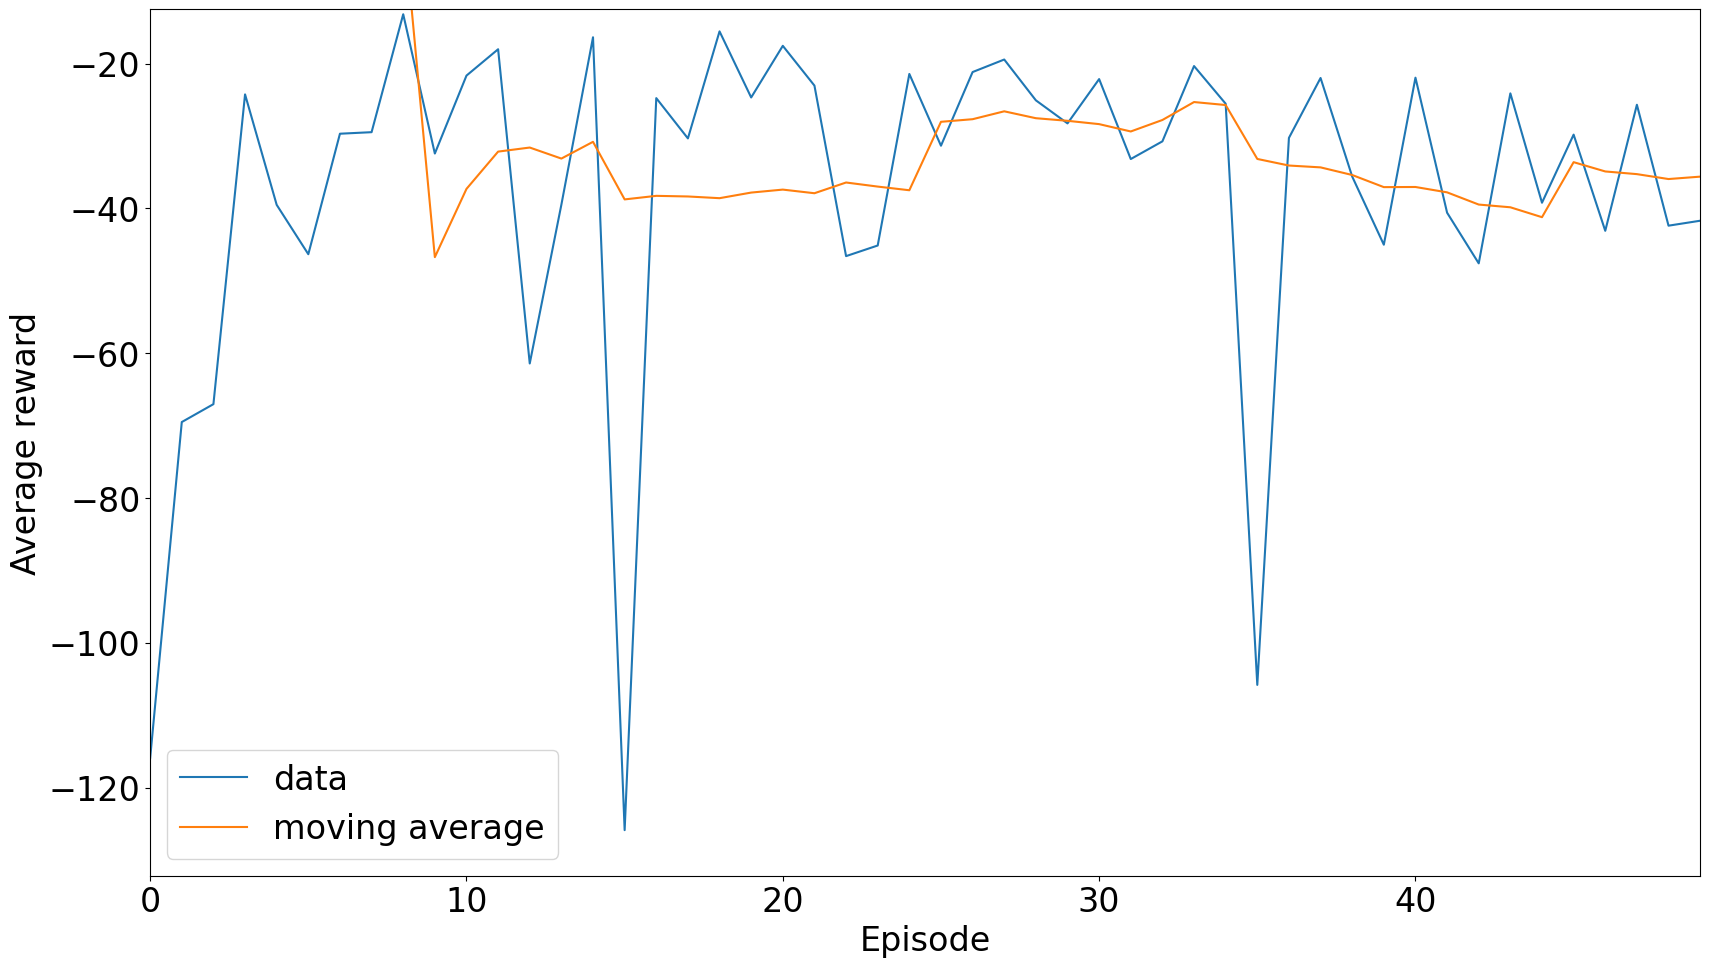

In [11]:
visualization.save_data_and_plot(data=simulation.reward_store, filename='reward', xlabel='Episode', ylabel='Average reward')  #np.log(-1*np.array((simulation.reward_store)))

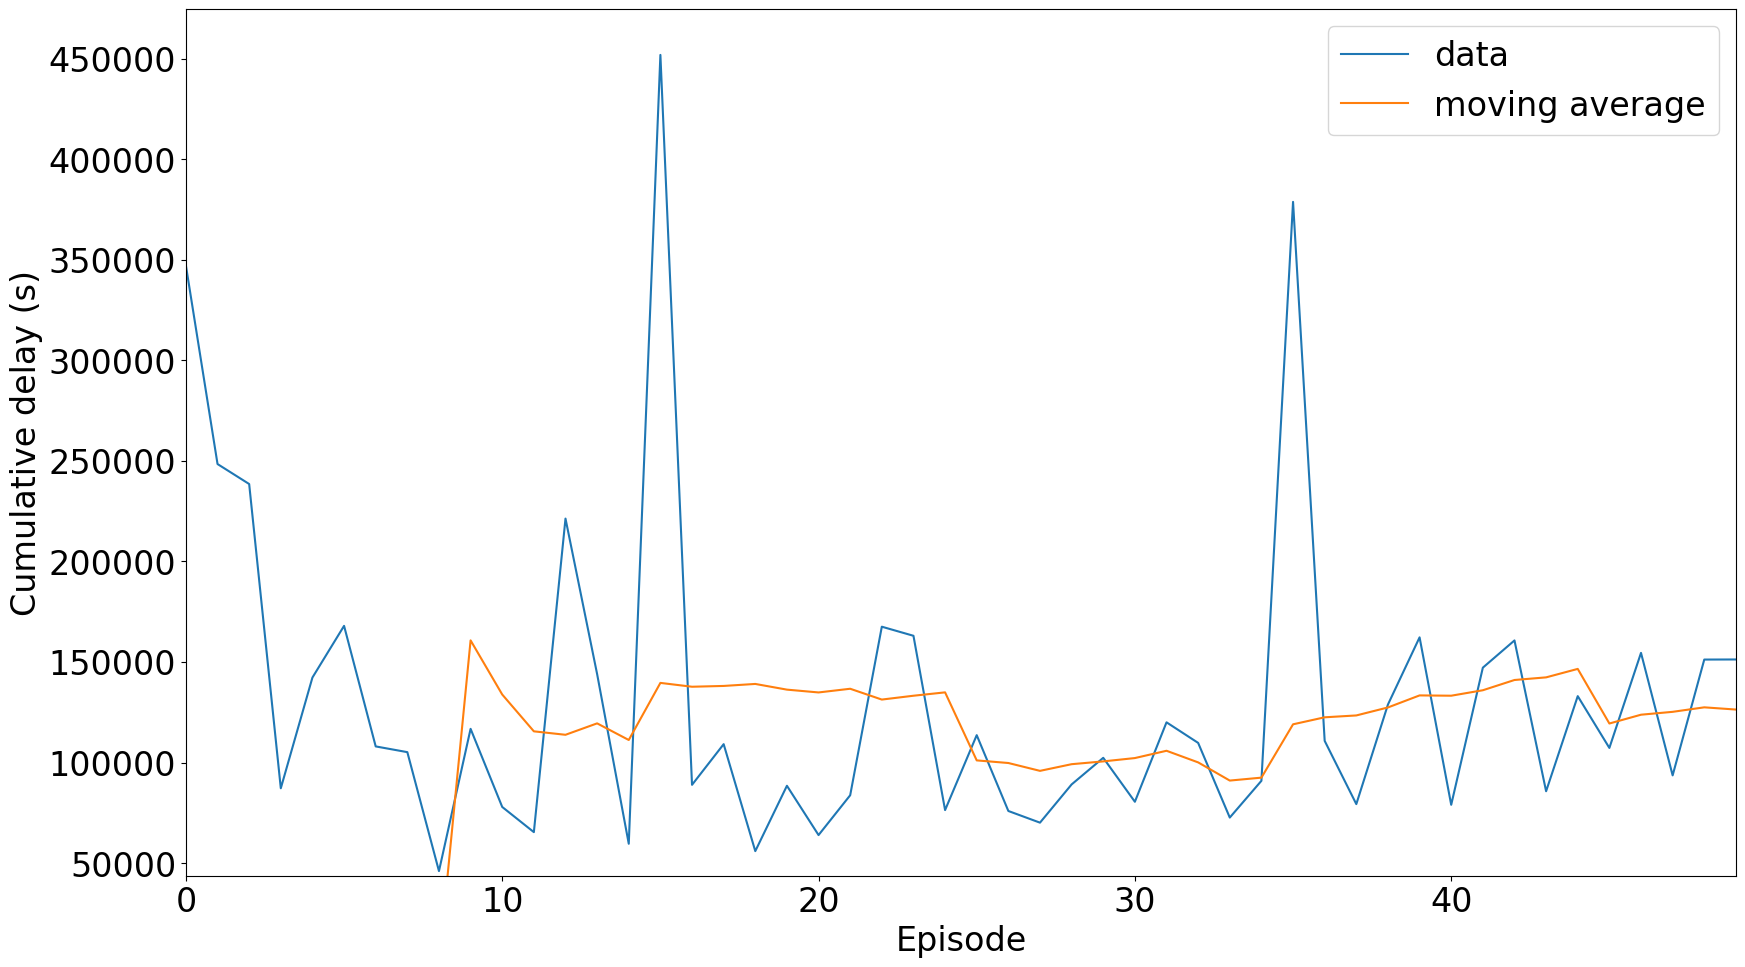

In [12]:
visualization.save_data_and_plot(data=simulation.cumulative_wait_store, filename='delay', xlabel='Episode', ylabel='Cumulative delay (s)')

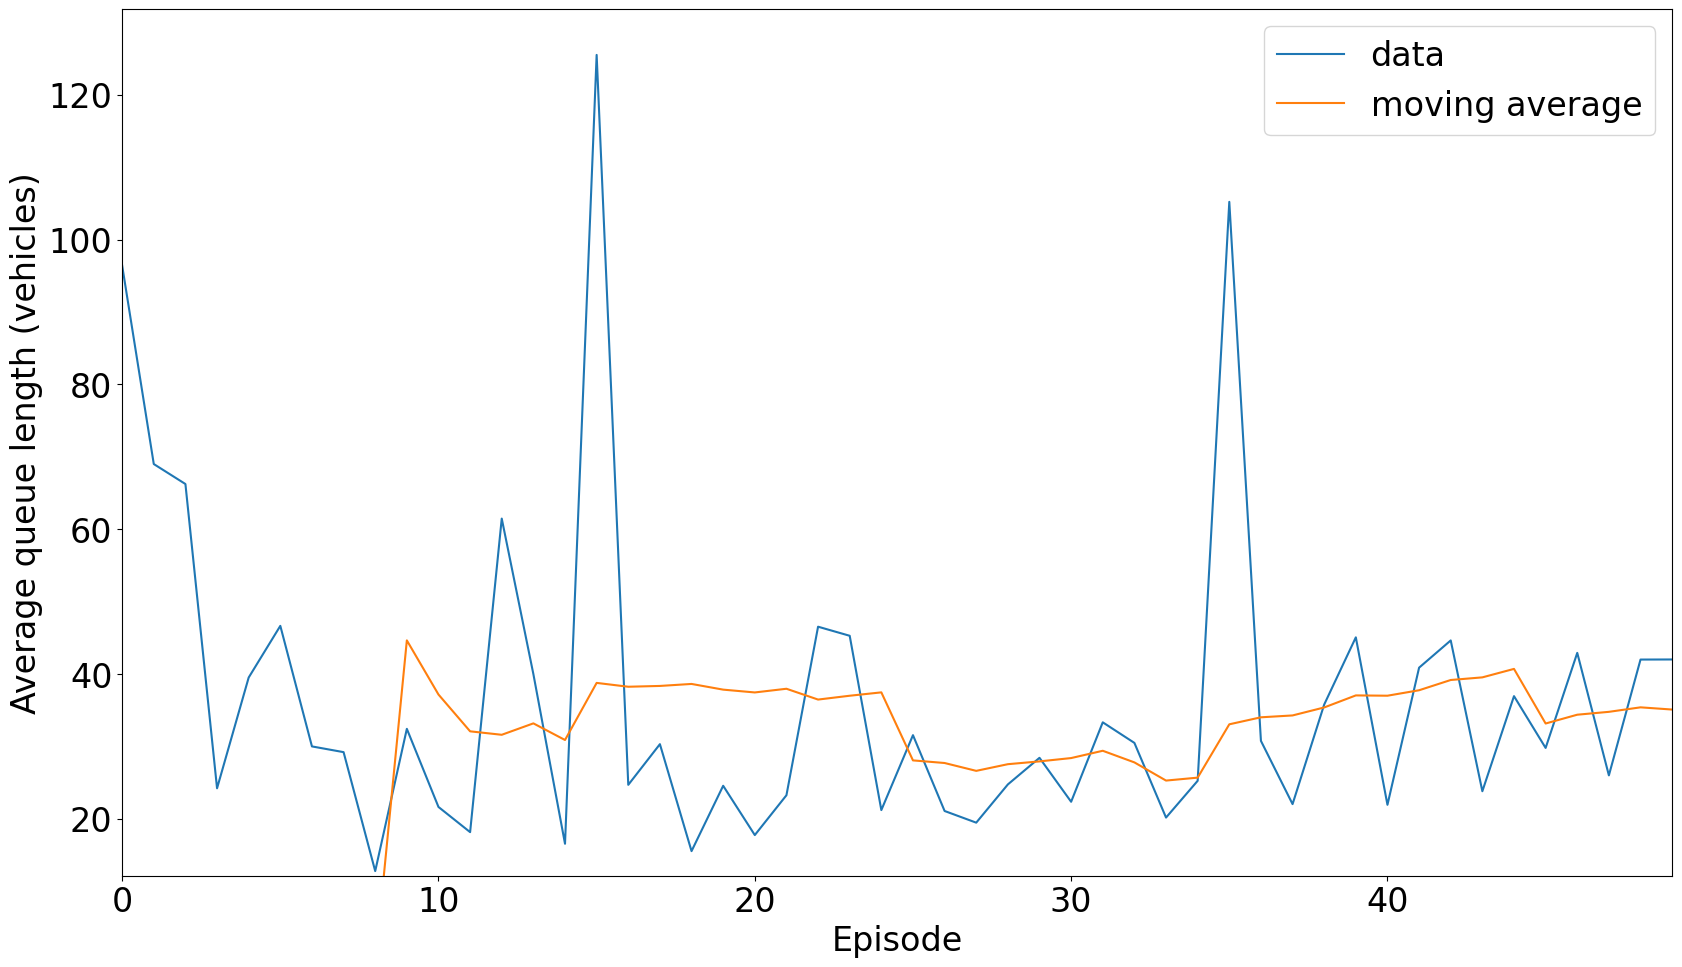

In [13]:
visualization.save_data_and_plot(data=simulation.avg_queue_length_store, filename='queue', xlabel='Episode', ylabel='Average queue length (vehicles)')

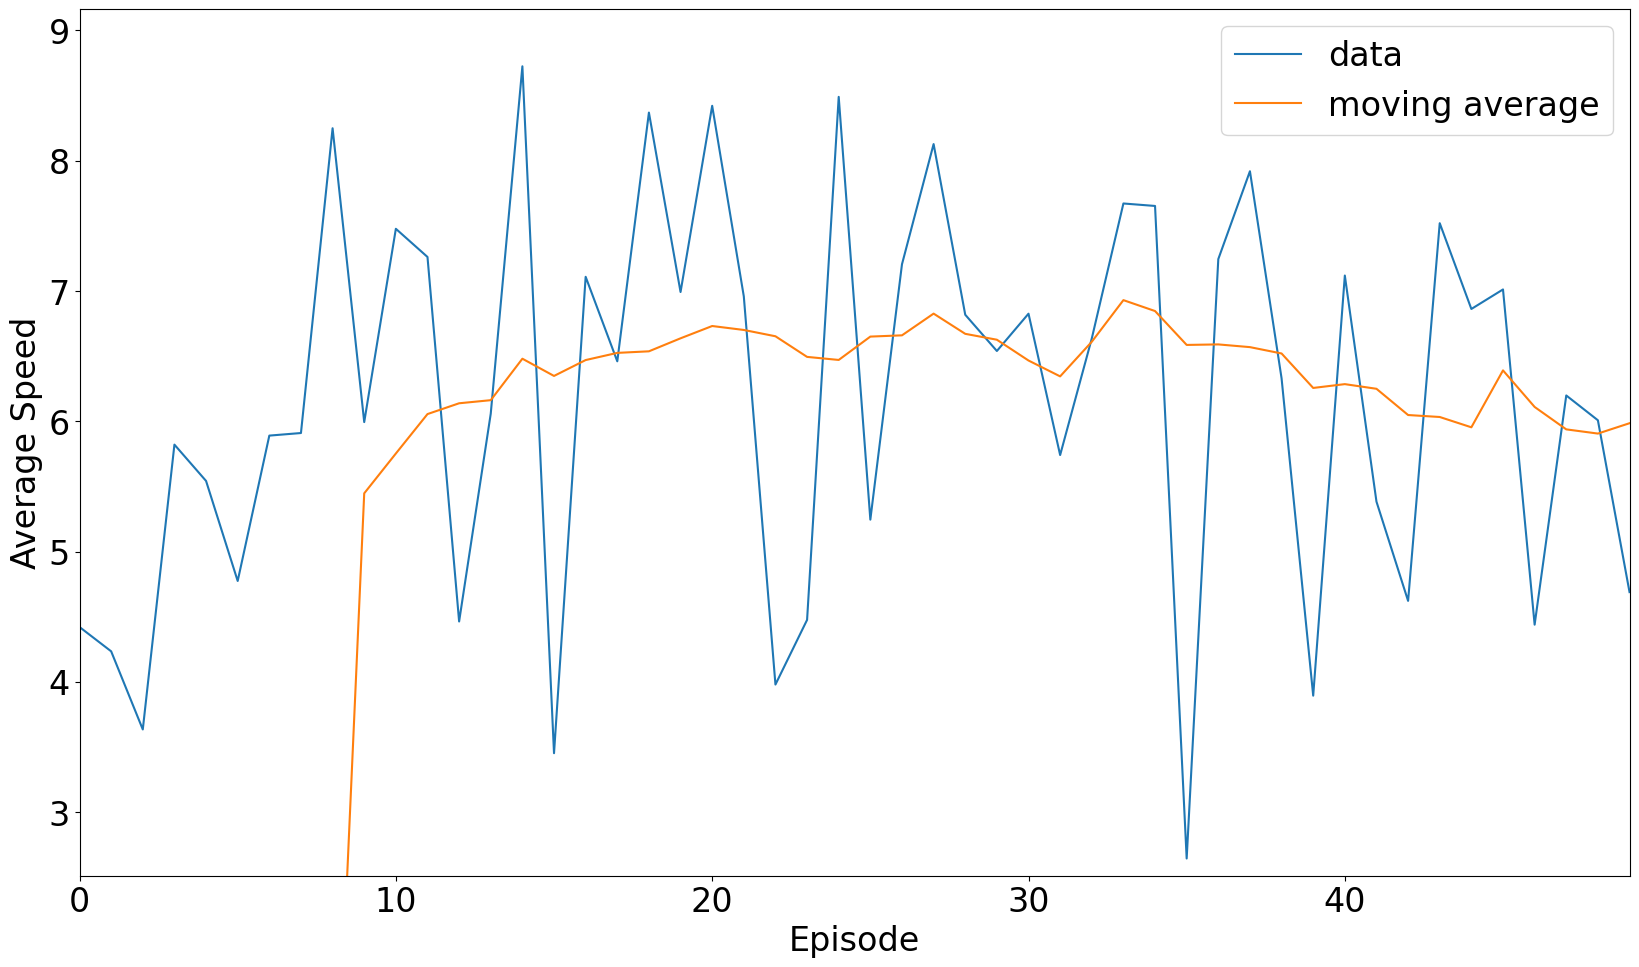

In [14]:
visualization.save_data_and_plot(data=simulation.speed_store, filename='Speed', xlabel='Episode', ylabel='Average Speed')

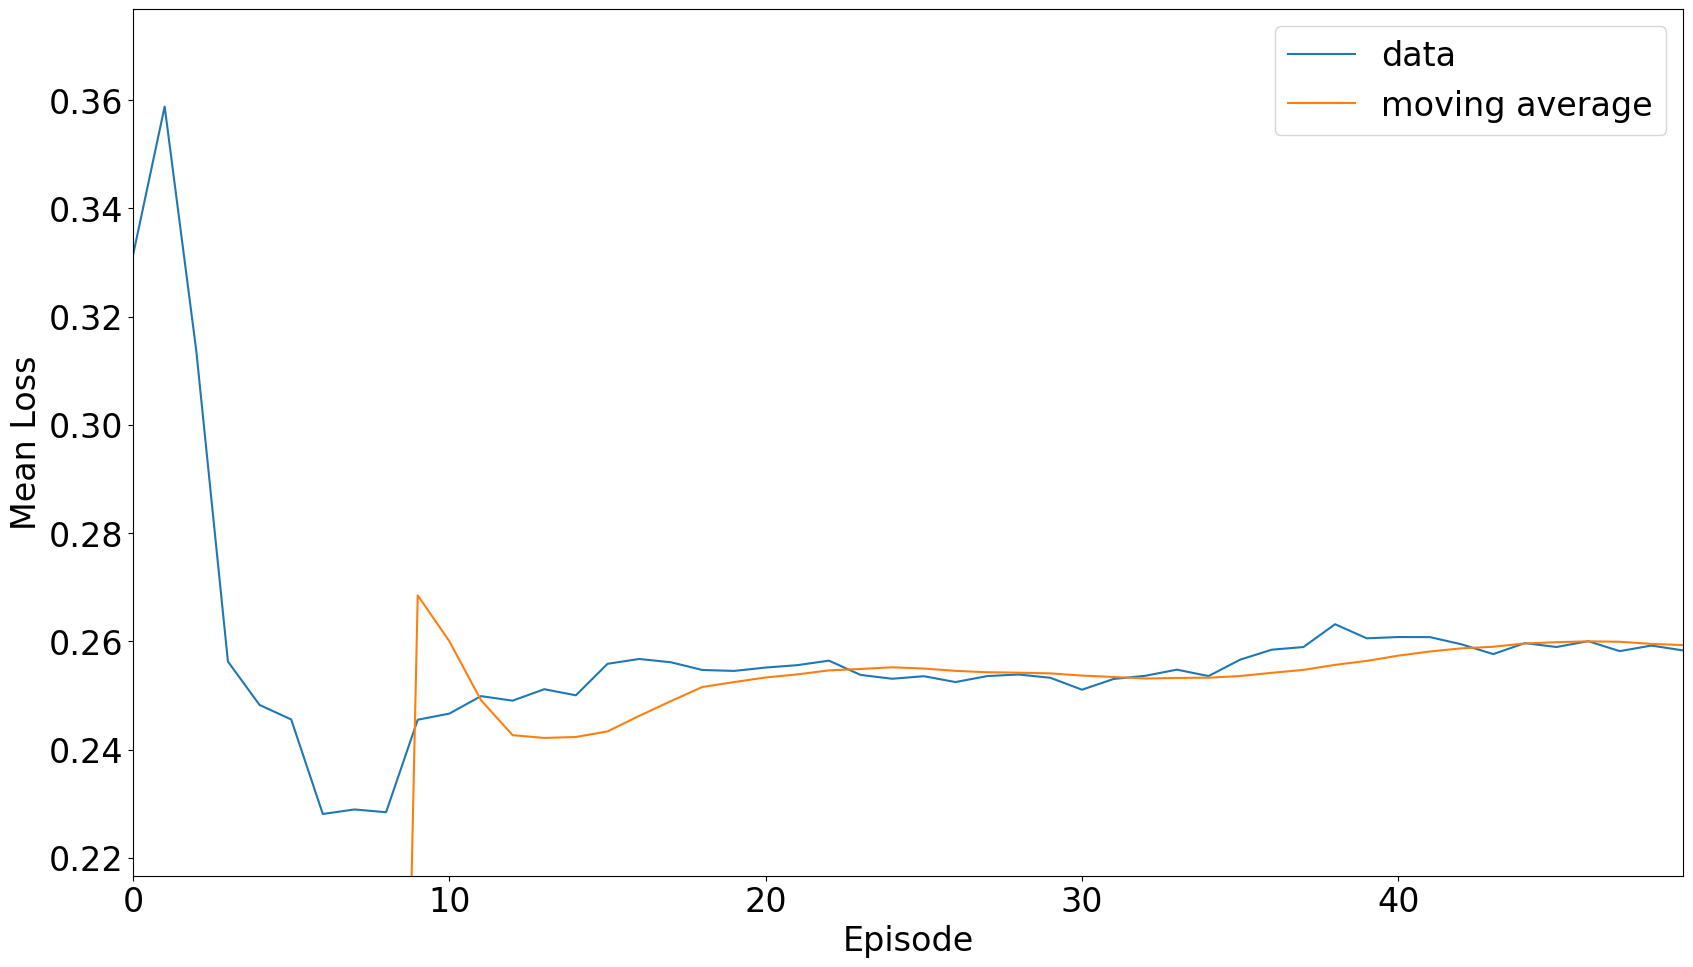

In [15]:
visualization.save_data_and_plot(data=simulation.training_losses, filename='train_loss', xlabel='Episode', ylabel='Mean Loss')